In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score

In [2]:
np.random.seed(2)

In [5]:
dataset = pd.read_csv('../input/Fraud/backup.csv')

In [6]:
dataset = dataset.drop('Unnamed: 0', axis = 1)
dataset = pd.get_dummies(dataset,prefix=['type'])

In [7]:
X = dataset.drop("isFraud",1)
y = dataset.isFraud

In [9]:
RandomState = 42


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

<AxesSubplot:>

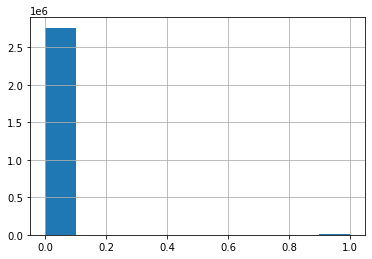

In [11]:
dataset.isFraud.hist()

In [12]:
n_features = X_train.shape[1]

In [13]:
print("Train Size: {}".format(len(X_train)))
print("Val Size: {}".format(len(X_val)))
print("Test Size: {}".format(len(X_test)))
print("No of Features: {}".format(n_features))

Train Size: 1243636
Val Size: 612538
Test Size: 914235
No of Features: 11


In [40]:
model = Sequential()
model.add(Dense(units=16, input_dim= n_features, activation='relu'))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=24, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_22 (Dense)             (None, 24)                408       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)                500       
_________________________________________________________________
dense_24 (Dense)             (None, 24)                504       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 25        
Total params: 1,629
Trainable params: 1,629
Non-trainable params: 0
____________________________________________________

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * (drop**((1 + epoch)/epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# model fitting
model.fit(X_train, y_train, batch_size=512, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stop, model_chkpoint, lrate_scheduler])

Train on 1243636 samples, validate on 612538 samples
Epoch 1/10
1243636/1243636 [==============================] - 20s 16us/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0033 - val_accuracy: 0.9991

Epoch 00001: val_loss improved from inf to 0.00329, saving model to best_model.h5
Epoch 2/10
1243636/1243636 [==============================] - 19s 15us/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0030 - val_accuracy: 0.9992

Epoch 00002: val_loss improved from 0.00329 to 0.00300, saving model to best_model.h5
Epoch 3/10
1243636/1243636 [==============================] - 20s 16us/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0028 - val_accuracy: 0.9992

Epoch 00003: val_loss improved from 0.00300 to 0.00279, saving model to best_model.h5
Epoch 4/10
1243636/1243636 [==============================] - 18s 14us/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0027 - val_accuracy: 0.9993

Epoch 00004: val_loss improved from 0.00279 to 0.00266, saving model to best_mode

In [45]:
y_pred = model.predict(X_test)

In [46]:
def rel(y_test,y_pred):
    predictionsRFR=np.array(y_pred,dtype='int') 
    CM_RFR = confusion_matrix(y_test,predictionsRFR)
    CR_RFR = classification_report(y_test,predictionsRFR)
    fprRFR, recallRFR, thresholdsRFR = roc_curve(y_test, predictionsRFR)
    AUC_RFR = auc(fprRFR, recallRFR)
    print("=============<>==================\n")
    resultsRFR = {"Confusion Matrix":CM_RFR,"Classification Report":CR_RFR,"Area Under Curve":AUC_RFR}
    for measure in resultsRFR:
        print(measure,": \n",resultsRFR[measure])
    print("=============<>==================\n")

In [47]:
rel(y_test,y_pred)

=============<>==================

Confusion Matrix : 
 [[911488      0]
 [  2308    439]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    911488
           1       1.00      0.16      0.28      2747

    accuracy                           1.00    914235
   macro avg       1.00      0.58      0.64    914235
weighted avg       1.00      1.00      1.00    914235

Area Under Curve : 
 0.5799053512923189
=============<>==================



In [52]:
pd.DataFrame(y_pred[y_pred==1]).count()

0    439
dtype: int64